In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import multiprocessing as mp
import gc
import datetime
from sklearn.preprocessing import LabelEncoder
import calendar
from scipy.sparse import csr_matrix,hstack
import tensorflow as tf
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from tqdm import tqdm
import pickle
import sys

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
data=pd.read_csv("/content/gdrive/MyDrive/PredictiveAnalyticsData/sales_train_evaluation.csv")
data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


In [ ]:
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1947 entries, id to d_1941
dtypes: int64(1941), object(6)
memory usage: 463.3 MB


In [ ]:
keys=pd.unique(data['cat_id'])
print('category of products',keys)
val=[]
for i in keys:
  ind=data.item_id[data['cat_id']==i]
  val.append(len(pd.unique(ind)))

category of products ['HOBBIES' 'HOUSEHOLD' 'FOODS']


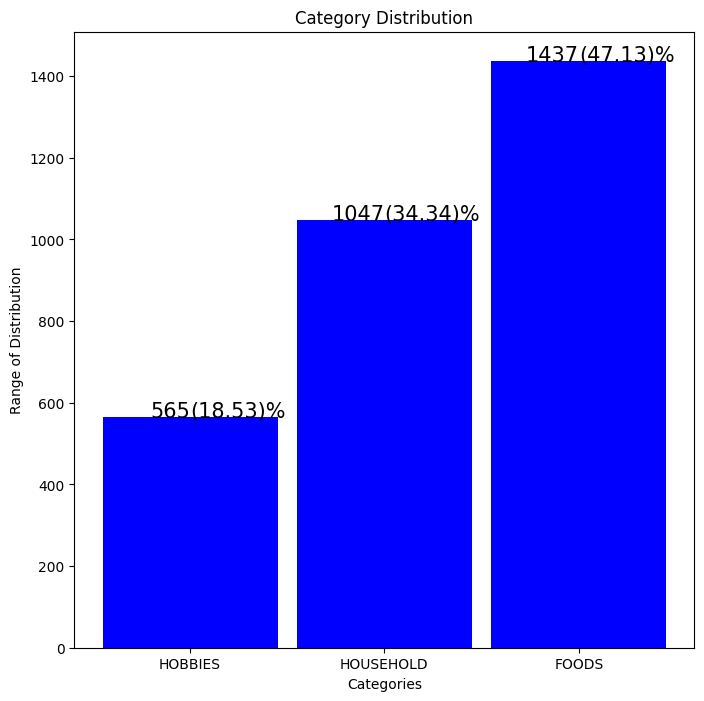

In [ ]:
# category of products ['HOBBIES' 'HOUSEHOLD' 'FOODS']
unique_items=len(data['item_id'].value_counts())
per=100/unique_items
plt.figure(figsize=(8,8))
plt.bar(keys, val, color ='blue',width=.9)
# plt.bar(keys, val, color ='maroon',width=.9)
for index,data1 in enumerate(val):
    plt.text(x=index , y =data1 , s=f"{data1}" , fontdict=dict(fontsize=15),ha='right')
    plt.text(x=index , y =data1 , s=f"({np.round(data1*per,2)})%" , fontdict=dict(fontsize=15),ha='left')

plt.title('Category Distribution')
plt.xlabel('Categories')
plt.ylabel('Range of Distribution')
plt.show()

In [ ]:
# Helper functions
def plot_time_series(data, ax=None, show=False):
    """Plot time series data."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(15, 5))
    for ind in data.index:
        ax.plot([int(col.split('_')[-1]) for col in data.columns],
                data.loc[ind].values, '-', label=ind)
    ax.legend(loc='best')
    ax.set_xlabel('Day')
    ax.set_ylabel('Items Sold')
    if show:
        plt.show(block=False)

def plot_aggregation(data):
    """Make plots over two time periods."""
    plot_time_series(data)
    print()
    plot_time_series(data[data.columns[-3*28:]])

In [ ]:
# Load data
print('Loading data...')
sell_price = pd.read_csv('/content/gdrive/MyDrive/PredictiveAnalyticsData/sell_prices.csv')
calendar = pd.read_csv('/content/gdrive/MyDrive/PredictiveAnalyticsData/calendar.csv')
train = pd.read_csv('/content/gdrive/MyDrive/PredictiveAnalyticsData/sales_train_validation.csv').set_index('id')
sample_sub = pd.read_csv('/content/gdrive/MyDrive/PredictiveAnalyticsData/sample_submission.csv')

# Get column groups
cat_cols = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
ts_cols = [col for col in train.columns if col not in cat_cols]
ts_dict = {t: int(t[2:]) for t in ts_cols}

# Describe data
print('  unique forecasts: %i' % train.shape[0])
for col in cat_cols:
    print('   N_unique %s: %i' % (col, train[col].nunique()))

Loading data...
  unique forecasts: 30490
   N_unique item_id: 3049
   N_unique dept_id: 7
   N_unique cat_id: 3
   N_unique store_id: 10
   N_unique state_id: 3


In [ ]:
# 1. All products, all stores, all states (1 series)
import plotly.express as px
days=data.columns[6:]
each_day_sale=data[days].sum().values

fig=px.line(x=calendar['date'][:1941],y=each_day_sale,title='Sales per Day',labels={'x':'Year','y':'Sales'})
fig.update_traces(line_color='red')
fig.update_layout(title_x=.5)
fig.show()

***Observation - Sales drop drastically at every year end***

In [ ]:

new=pd.read_csv('/content/gdrive/MyDrive/PredictiveAnalyticsData/calendar.csv',nrows=1941)
new=new.fillna('no_event')
new['sales']=each_day_sale

new.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sales
0,2011-01-29,11101,Saturday,1,1,2011,d_1,no_event,no_event,no_event,no_event,0,0,0,32631
1,2011-01-30,11101,Sunday,2,1,2011,d_2,no_event,no_event,no_event,no_event,0,0,0,31749
2,2011-01-31,11101,Monday,3,1,2011,d_3,no_event,no_event,no_event,no_event,0,0,0,23783
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,no_event,no_event,no_event,no_event,1,1,0,25412
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,no_event,no_event,no_event,no_event,1,0,1,19146


In [ ]:
#creating function for average sales
def avg_sales(input,titles,label,size):
  group=new.groupby(input).mean()  #grouping that division and finding the mean

  plt.figure(figsize=size)
  ax=sns.barplot(x=group.index,y=group['sales'])
  for p in ax.patches:
      ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha='center', va='center', fontsize=11, xytext=(0, 20),textcoords='offset points')
  plt.title(titles)
  plt.xlabel(label)
  plt.ylabel('sales')
  plt.show()

In [ ]:
#creating function for average sales
def avg_sales(input,titles,label,size):
  group=new.groupby(input).mean()  #grouping that division and finding the mean

  plt.figure(figsize=size)
  ax=sns.barplot(x=group.index,y=group['sales'])
  for p in ax.patches:
      ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha='center', va='center', fontsize=11, xytext=(0, 20),textcoords='offset points')
  plt.title(titles)
  plt.xlabel(label)
  plt.ylabel('sales')
  plt.show()

In [ ]:
import plotly.graph_objects as go

In [ ]:
#creating the functions for daily sales,monthly sales and also barplot visulaization to know the total sales

def daily_sales(input,title,xlabel,ylabel): #takes the input like stateid,storeid
  fig1 = go.Figure()
  value=data.groupby(input).sum()     #do groupng for it
  states=len(value.index)             #get the indices

  for i in range(states):
    fig1.add_trace(go.Scatter(x=calendar['date'][:1941],y=value.iloc[i],name=value.index[i]))
  fig1.update_layout(title=title, title_x=0.5,xaxis_title=xlabel,yaxis_title=ylabel)

  return fig1.show()



#montly sales i.e in each year we get the sales for each month in it
def month_sales(input,title,xlabel,ylabel): #takes the input
  fig2 = go.Figure()
  value=data.groupby(input).sum().T  #grouping the data
  index=value.columns
  dates=new['date'].map(lambda x:x[:-3]).values  #we need to get the month-year so we removing the date from it,so that we can group the month-year combintation to get monthly sales
  value['date']=dates
  final=value.groupby('date').sum()   #finally grouping with month-year combintations(like 2001-1,2001-2,2001-3 i.e 1,2,3 are months)

  for i in index:
    fig2.add_trace(go.Scatter(x=final.index,y=final[i],name=i))
  fig2.update_layout(title=title, title_x=0.5,xaxis_title=xlabel,yaxis_title=ylabel)
  return fig2.show()


#getting barplot visualixation for overall sales
def bar_plots(input,title,xlabel,ylabel):
  fig3 = go.Figure()
  value=data.groupby(input).sum()
  total_sales=value.iloc[:].sum(axis=1)   #summing up sales of each proudct ie consider all days sales for each item

  percents=[np.round(i*(100/sum(total_sales.values)),2) for i in total_sales.values]
  fig3=px.bar( x=total_sales.index,y=total_sales.values,color=total_sales.index,text=percents)
  fig3.update_traces(textposition='outside')
  fig3.update_layout(title=title, title_x=0.5,width=1000, height=500,xaxis_title=xlabel,yaxis_title=ylabel)
  return fig3.show()


In [ ]:
daily_sales('state_id','State-wise sales','Year','Sales')

<ipython-input-16-5fdff4404352>:5: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



In [ ]:

month_sales('state_id','Monthly State-wise Sales','Year','Sales')

<ipython-input-16-5fdff4404352>:19: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



In [ ]:
bar_plots('state_id','State-wise Sales','State','Sales (in millions)')

<ipython-input-16-5fdff4404352>:34: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



***California sales are greater than the other two states and the other two states- WI and TX follow similar sales trend***

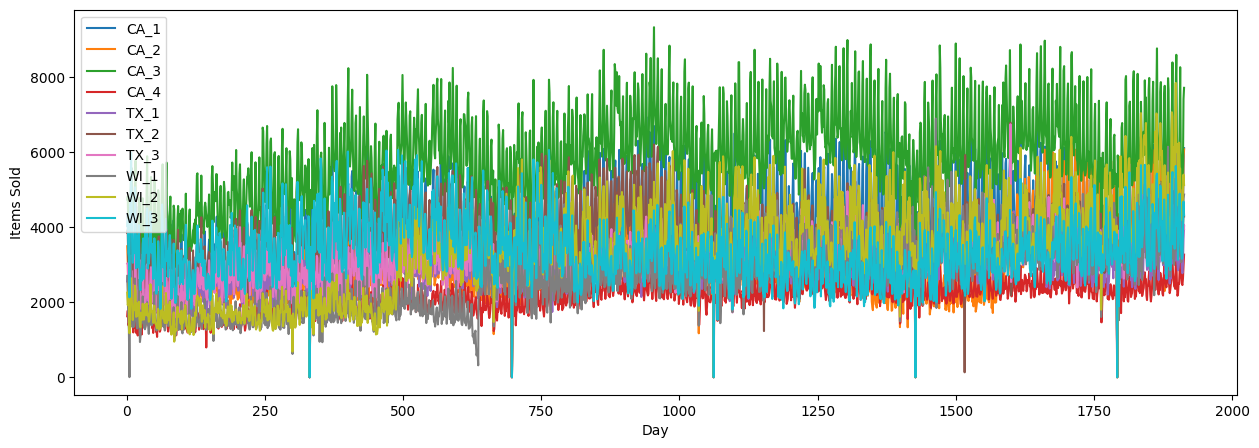

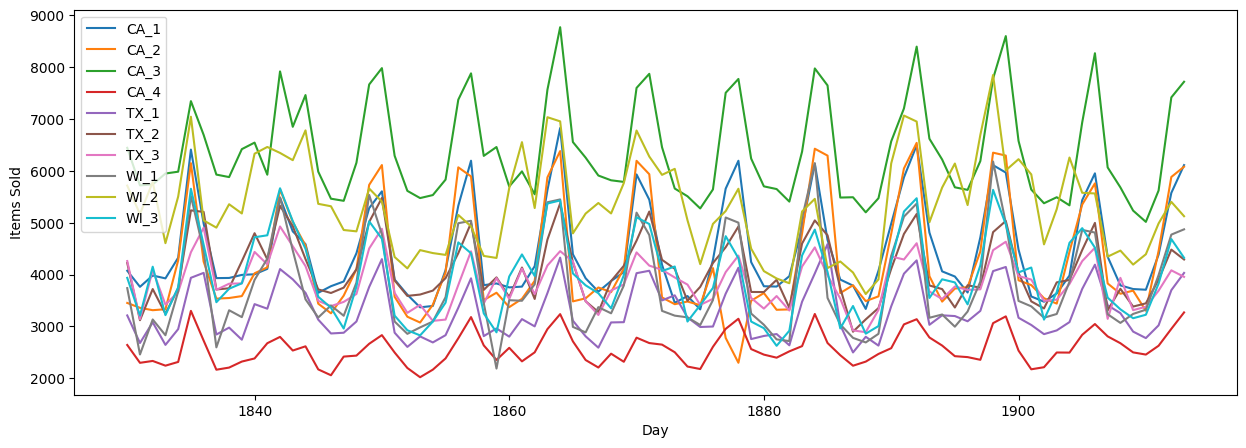

In [ ]:
# 3. All products by store (10 series)
store_sales = train.groupby('store_id')[ts_cols].sum()
plot_aggregation(store_sales)